In [1]:
from google.colab import drive
drive.mount('/content/drive/')

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU, Activation, Dropout

Mounted at /content/drive/


In [2]:
import os
import cv2
from sklearn.model_selection import train_test_split

def load_images(folder_path):
    image_list = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img = cv2.imread(os.path.join(folder_path, filename))
            img_array = np.array(img) / 255.0
            image_list.append(img_array)
    return np.array(image_list)

folder_path = "/content/drive/My Drive/2023_spring/DS340/DS340_GroupProject/data/smd"
x_data = load_images(folder_path)

In [3]:
x_data.shape

(1347, 64, 64, 3)

In [4]:
import tensorflow as tf
import numpy as np

dataset = tf.data.Dataset.from_tensor_slices(x_data)

# Set the batch size
BATCH_SIZE = 128
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [12]:
NOISE_DIM = 200
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras import layers
latent_size = 100

def generator():
    model = tf.keras.models.Sequential([
        layers.InputLayer(input_shape=(latent_size,)),
        layers.Reshape((1, 1, latent_size)),
        layers.Conv2DTranspose(1024, kernel_size=4, strides=1, padding='valid', use_bias=False,kernel_initializer=HeNormal()),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # out: 512 x 4 x 4
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding='same', use_bias=False,kernel_initializer=HeNormal()),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # out: 256 x 8 x 8
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', use_bias=False,kernel_initializer=HeNormal()),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # out: 128 x 16 x 16
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False,kernel_initializer=HeNormal()),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # out: 64 x 32 x 32
        layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', use_bias=False,kernel_initializer=HeNormal()),
        layers.Activation('tanh')
    ])

    return model

generator_model = generator()

In [13]:
generator_model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 4, 4, 1024)       1638400   
 ranspose)                                                       
                                                                 
 re_lu_4 (ReLU)              (None, 4, 4, 1024)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 4, 4, 1024)       4096      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 8, 8, 512)       

In [14]:
def denormalize(image):
    return ((image + 1) * 127.5)

def display_image(image):
    denorm_image = denormalize(image)
    denorm_image = denorm_image.astype(np.uint8)  # Convert to integer values in the range [0..255]
    plt.imshow(denorm_image)
    plt.axis('off')
    plt.show()

def display_image(image):
    denorm_image = denormalize(image)
    plt.imshow(denorm_image)
    plt.axis('off')
    plt.show()

def display_batch(images, title):
    fig = plt.figure(figsize=(6, 6))
    plt.suptitle(title)

    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

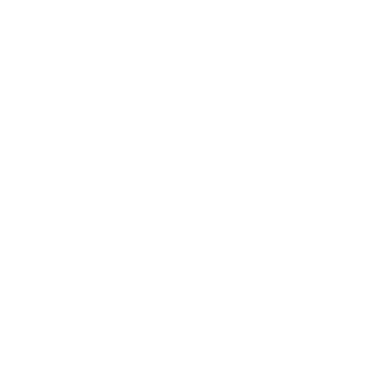

In [15]:
# Test generator
noise_vector = np.random.normal(0, 1, (100, latent_size))
output_fake = generator_model(noise_vector).numpy()[99]
display_image(output_fake)

In [16]:
def discriminator(input_shape=(64,64,3)):
  
    """Compute discriminator score for a batch of input images.
      
    Inputs:
    - x: tensor, shape [number of images in one batch, 128, 128, 3]
    
    Returns:
    TensorFlow Tensor with shape [number of images in one batch, 1], containing the score 
    for an image being real for each input image.
    """
    model = tf.keras.Sequential([
        # in: 3 x 64 x 64
        layers.Conv2D(64, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(64, 64, 3)),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),

        # out: 64 x 32 x 32
        layers.Conv2D(128, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),

        # out: 128 x 16 x 16
        layers.Conv2D(256, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),

        # out: 256 x 8 x 8
        layers.Conv2D(512, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),

        # out: 512 x 4 x 4
        layers.Conv2D(1, kernel_size=4, strides=1, padding='valid', use_bias=False),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        
        # out: 1 x 1 x 1
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
])


    return model

discriminator_model = discriminator()

In [17]:
discriminator_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3072      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 batch_normalization_9 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                      

In [18]:
discriminator_model(generator_model(noise_vector))

<tf.Tensor: shape=(100, 1), dtype=float32, numpy=
array([[0.50004786],
       [0.50004137],
       [0.49994326],
       [0.5000997 ],
       [0.5000432 ],
       [0.5001081 ],
       [0.500052  ],
       [0.5000678 ],
       [0.5000701 ],
       [0.5000803 ],
       [0.50002056],
       [0.50010395],
       [0.5000316 ],
       [0.5000701 ],
       [0.5001055 ],
       [0.5001082 ],
       [0.5001604 ],
       [0.500081  ],
       [0.50003284],
       [0.50002205],
       [0.49995512],
       [0.50000083],
       [0.5001104 ],
       [0.5001185 ],
       [0.50010127],
       [0.50004965],
       [0.5001148 ],
       [0.50008523],
       [0.50005805],
       [0.50002337],
       [0.5000813 ],
       [0.5000722 ],
       [0.50005364],
       [0.500012  ],
       [0.50004333],
       [0.5000945 ],
       [0.5000929 ],
       [0.50004315],
       [0.5000842 ],
       [0.50004643],
       [0.5000766 ],
       [0.50010085],
       [0.5000455 ],
       [0.5000424 ],
       [0.50011635],
     

In [19]:
def generator_loss(fake_score):
    # We use Wassertein loss here 
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_score), fake_score)

def disciminator_loss(real_score,fake_score):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_score), real_score)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_score), fake_score)

    return fake_loss + real_loss

@tf.function
def train_G(noise,generator_model,discriminator_model,generator_optimizer):
  with tf.GradientTape() as gen_tape:
    fake_images = generator_model(noise, training=True)
    fake_score = discriminator_model(fake_images, training=False)
    G_loss = generator_loss(fake_score)

  generator_gradients = gen_tape.gradient(G_loss, generator_model.trainable_weights)
  generator_optimizer.apply_gradients(zip(generator_gradients, generator_model.trainable_weights))
  return G_loss,fake_images

@tf.function
def train_D(noise,real_images,generator_model,discriminator_model,discriminator_optimizer):

  with tf.GradientTape() as dis_tape:
    fake_images = generator_model(noise, training=False)
    real_score = discriminator_model(real_images, training=True)
    fake_score = discriminator_model(fake_images, training=True)
    D_loss = disciminator_loss(real_score,fake_score)
    disciminator_gradients = dis_tape.gradient(D_loss, discriminator_model.trainable_weights)

  discriminator_optimizer.apply_gradients(zip(disciminator_gradients, discriminator_model.trainable_weights))

  
  return D_loss,real_score,fake_score

def train_gan(dataset, generator_model, discriminator_model, generator_optimizer,discriminator_optimizer, epochs):
  history_GL = []
  history_FS = []
  history_DL = []
  history_RS = []

  for epoch in range(epochs):
    gen_loss_sum = 0
    disc_loss_sum = 0
    num_batches = 0
    fake_score_sum = 0
    real_score_sum = 0

    for image_batch in dataset:
      for _ in range(1):
        noise = tf.random.normal([image_batch.shape[0], NOISE_DIM])
        D_loss,real_score,fake_score = train_D(noise,image_batch,generator_model,discriminator_model,discriminator_optimizer)
      
      for _ in range(4):
        noise = tf.random.normal([image_batch.shape[0], NOISE_DIM])
        G_loss,fake_images = train_G(noise,generator_model,discriminator_model,generator_optimizer)

      gen_loss_sum += G_loss
      disc_loss_sum += D_loss
      num_batches += 1
      fake_score_sum += np.mean(fake_score.numpy())
      real_score_sum += np.mean(real_score.numpy())

    if epoch % 5 == 0:
      generated_images = fake_images.numpy()[0:9]
      denorm_images = [denormalize(img) for img in generated_images]
      display_batch(denorm_images, f"Generated images at epoch {epoch + 1}")

    history_GL.append(gen_loss_sum/num_batches)
    history_FS.append(fake_score_sum/num_batches)
    history_DL.append(disc_loss_sum/num_batches)
    history_RS.append(real_score_sum/num_batches)

    print(f'Epoch {epoch+1}, Generator Loss: {gen_loss_sum/num_batches}, fake score: {fake_score_sum/num_batches}, Discriminator Loss: {disc_loss_sum/num_batches}, real score: {real_score_sum/num_batches}')
  
  return history_GL, history_FS, history_DL, history_RS

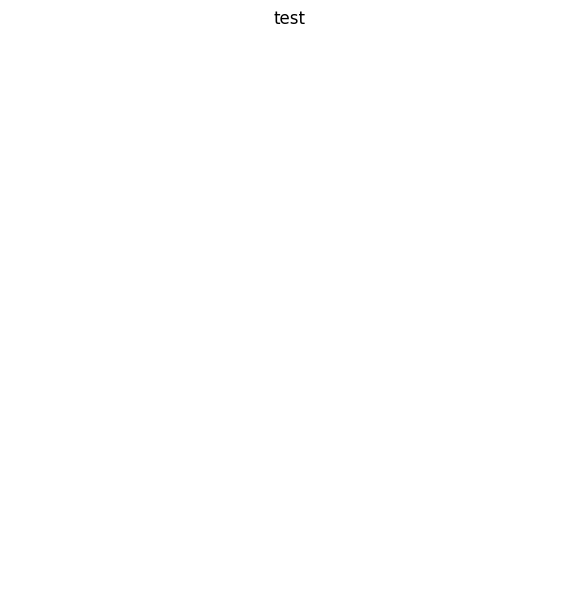

tf.Tensor(
[[0.44148245]
 [0.5329007 ]
 [0.51866764]
 [0.42509335]
 [0.5652539 ]
 [0.5008769 ]
 [0.6922545 ]
 [0.42439   ]
 [0.49529433]
 [0.5291464 ]
 [0.5244314 ]
 [0.4770115 ]
 [0.45320457]
 [0.4498925 ]
 [0.5612697 ]
 [0.42558357]
 [0.7364688 ]
 [0.44372797]
 [0.45377097]
 [0.6394039 ]
 [0.59522474]
 [0.50718766]
 [0.50187874]
 [0.48278713]
 [0.437744  ]
 [0.4555223 ]
 [0.63131195]
 [0.46418035]
 [0.6477187 ]
 [0.710037  ]
 [0.44767985]
 [0.53529704]
 [0.5477839 ]
 [0.4626019 ]
 [0.43566492]
 [0.4348055 ]
 [0.55311525]
 [0.46413904]
 [0.5338405 ]
 [0.64873123]
 [0.42208564]
 [0.44420853]
 [0.52538276]
 [0.44041383]
 [0.46051806]
 [0.5934313 ]
 [0.47080672]
 [0.5109282 ]
 [0.4625094 ]
 [0.4448325 ]
 [0.44980955]
 [0.4439097 ]
 [0.44815987]
 [0.44970143]
 [0.45720643]
 [0.43829697]
 [0.5569504 ]
 [0.666295  ]
 [0.49578226]
 [0.43985313]
 [0.5077217 ]
 [0.4478026 ]
 [0.5644799 ]
 [0.47893873]
 [0.4635531 ]
 [0.4650499 ]
 [0.4537423 ]
 [0.5169214 ]
 [0.444991  ]
 [0.61111003]
 [0.51424

/usr/local/lib/python3.9/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


tf.Tensor(0.7050331, shape=(), dtype=float32)


In [21]:
generator_model = generator()
noise = np.random.normal(0, 1, (100, latent_size))
fake_images = generator_model(noise,training=False)
generated_images = fake_images.numpy()[0:9]
denorm_images = [denormalize(img) for img in generated_images]
display_batch(denorm_images,"test")

discriminator_model = discriminator()
fake_score = discriminator_model(fake_images, training=True)
print(fake_score)
print(generator_loss(fake_score))